<font size="5">Build Your Own ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- generate an unstructure mesh

- set initial conditions and boundary tags

    
- prepare configuration files for running the model




</font>

<font size="3">Before you can run this notebook, you should have run the 3_Set_Boundaries</font>


<font size=3> Give the name of your study area, must be the same in all notebooks </font>


<font size=5> Install packages. <font> <br>
<font size=3> If the cell runs successfully, this only needs to be done 1 time. <font>

In [3]:
import os
os.chdir('/content')
! rm -rf '/content/orinoco'
#! rm -rf '/content/anuga_core'
if os.path.isdir('/content/komo_estuary_tutorial') == False:
  print('Pulling the git repository with files for the tutorial\n')
  ! git clone https://github.com/achri19/komo_estuary_tutorial.git
else:
  print('Updating the local git repository \n')
  os.chdir('/content/komo_estuary_tutorial')
  ! git pull 

print('\nInstalling the Python packages needed for these tutorials\n')
!/bin/bash /content/komo_estuary_tutorial/install_packages.sh



Updating the local git repository 

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/achri19/komo_estuary_tutorial
   3f3fc01..c7539bb  main       -> origin/main
Updating 3f3fc01..c7539bb
Fast-forward
 install_packages.sh | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)

Installing the Python packages needed for these tutorials

(1) Install pip packages
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/simard-landscape-lab/orinoco.git to /tmp/pip-req-build-d8u5xwci
  Running command git clone -q https://github.com/simard-landscape-lab/orinoco.git /tmp/pip-req-build-d8u5xwci
     |████████████████████████████████| 438 kB 5.

<font size=5> Mount Google Drive and Grant Access <font> <br>


<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [9]:
import sys
path = os.getcwd() + '/'
where_to_mount = '/content/drive/'

from google.colab import drive
drive.mount(where_to_mount, force_remount=True)

Mounted at /content/drive/


There is a folder of necessary files located here: 
https://drive.google.com/drive/folders/1Q0UglZJhOsK2_v7pOuX_FIN60d-gYnM7?usp=sharing

Click on this link and add a SHORTCUT TO DRIVE. This will link this folder to your personal Google Drive and make it accessible to this notebook.

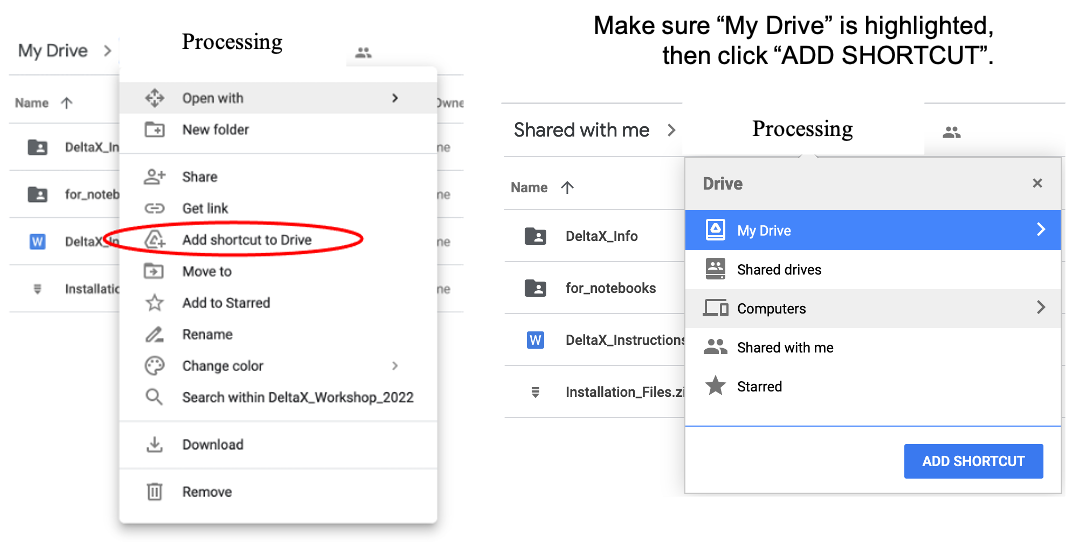

<font size= 5 color = 'red'> Set directories

In [10]:
path = where_to_mount + 'MyDrive/'
path_code = where_to_mount + 'MyDrive/processing/code/'
path_templates = where_to_mount + 'MyDrive/processing/templates/'
path_configs = where_to_mount + 'MyDrive/processing/configs/'
path_examples = where_to_mount + 'MyDrive/examples/'
path_ancillary = where_to_mount + 'MyDrive/processing/ancillary/'
try:
  os.mkdir(path_examples)
except:''
sys.path.insert(1,path_code)


<font size= 5 color = 'red'> Import necessary packages

In [11]:
# Standard packages
import os
import time
import sys
import fnmatch
import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
from datetime import datetime
from string import Template
import geopandas as gpd
from shapely.geometry import Polygon, Point
import rasterio
from pathlib import Path
from shapely.geometry import LineString

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier
from anuga.parallel.parallel_inlet_operator import Parallel_Inlet_operator

## Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

#mpl.rcParams['animation.ffmpeg_path'] = r'/Users/alchrist/Downloads/ffmpeg'
## If you get an error with producing animation plots, uncomment the line above and add directory for ffmpeg (r'/PATH/TO/ffmpeg')
import matplotlib.animation as animation
writer = animation.FFMpegWriter(fps=60)



In [12]:
from fix_polygons import getpolygonpoints, removenearbypoints, delete_holes
from BYOM_Utilities_V1 import (build_directory,
                               get_extent_parameters,
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, 
                               set_boundary_conditions, 
                               make_watermask,
                               more_opening)
from BYOM_extra import make_mesh_polygons, determine_riverscale



/content/drive/MyDrive/processing/code/raster_bridges.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/content/drive/MyDrive/processing/code/raster_bridges.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')
/usr/local/lib/python3.7/dist-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/usr/local/lib/python3.7/dist-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


<font size='5' color = 'red' > Set Boundaries <br> Set the AOI again and make sure the working directory is set. If you ran 2_Setup_DEM notebook then the directory should already be made. </font>


<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

In [13]:
AOI = 'komo'
elev_name = 'Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni0m_lakes-uni1m'
elevationpath = '/content/drive2/MyDrive/examples/komo/DEMs/Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni0m_lakes-uni1m'
Path((path_examples + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)




Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/examples/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 

<font size = 5> We will now build the mesh/domain for the model. This file will be saved and can be reused for multiple simulations.

<font size =5 color='red'> Get Parameters </font>

In [14]:

parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG            = int(parameters['EPSG'][0])                         # Coordinate system



In [15]:
try:
    ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[8],AOI,res))
except:
    os.system('gdalwarp -overwrite -tr %s %s %s%s_GEBCO_%s.tif %s%s_GEBCO_%s.tif '\
              ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
              %(xres,yres,folders[8],AOI,ref_res,folders[8],AOI,xres,ulx,lry,lrx,uly))
    ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[8],AOI,res))
    
ref_profile = ref.profile


<font size=5 color='red'> Get model domain, determine tidal boundary

In [16]:
model_domain = gpd.read_file('%s%s_input.shp' %(folders[0],AOI))
domain_name = folders[3] + 'TEST/'
Path(domain_name).mkdir(parents=True, exist_ok=True)

try:
    tide_bnd = gpd.read_file('%s%s_tidebnd.shp' %(folders[0],AOI))
    tide_bnd.to_file('%s%s_tidebnd.shp' %(domain_name,AOI))
except:
    print('Tidal boundary is not defined yet')
    tide_bnd_EPSG = []
    tideLAT_EPSG = -9999
    tideLON_EPSG = -9999

else:
    print('Tidal boundary is defined by User File (%s_tidebnd.shp)' %(AOI))
    if tide_bnd.crs != 'EPSG:4326':
        tide_bnd = tide_bnd.to_crs('EPSG:4326')    
    tide_centroid = tide_bnd.centroid

    tide_bnd_EPSG = tide_bnd.to_crs('EPSG:%s' %(EPSG))
    tide_EPSG_centroid = tide_bnd_EPSG.centroid

    tideLAT_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[1][0],2)
    tideLON_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[0][0],2)



ERROR:fiona._env:/content/drive/MyDrive/examples/komo/User_Defined_Files/komo_tidebnd.shp: No such file or directory


Tidal boundary is not defined yet


In [17]:
# boundary_segments,tideLON_EPSG,tideLAT_EPSG = get_tidal_boundary(AOI,folders,res,parameters,tide_bnd_EPSG,tideLAT_EPSG,tideLON_EPSG)

# tides = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x=[tideLON_EPSG],y=[tideLAT_EPSG]),crs='EPSG:%s' %(EPSG))

# print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_EPSG,tideLON_EPSG))

# tideLON_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[0][0],4)
# tideLAT_4326 = round(tides.to_crs('EPSG:4326').geometry[0].coords.xy[1][0],4)

# print('Tide centroid is LAT: %s LON: %s ' %(tideLAT_4326,tideLON_4326))

# tide_path = folders[5] + '/Tide_LAT%s_LON%s/' %(tideLAT_4326,tideLON_4326)

# Path(tide_path).mkdir(parents=True, exist_ok=True)



In [18]:

# boundary_segments.plot(categorical=True,legend=True,column='boundary')
# boundary_segments.to_file('%s%s_Boundary_Segments.shp' %(domain_name,AOI))

<font size=5 color='red'> Get median river width to determine scale of mesh in river polygons </font>

In [19]:
segment_width = 150
pixel_step = int(round(segment_width/res))

if os.path.isfile("%s%s_widths_%sx%s.tif" %(folders[8],AOI,res,pixel_step))==False:
    distance,widths = make_channel_networks(folders,
                                            AOI,
                                            ref,
                                            parameters,
                                            pixel_step,
                                            os.path.isfile("%s%s_widths_%sx%s.tif" %(folders[8],AOI,res,pixel_step)))
med_width, riverscale, cellsperwidth = determine_riverscale(folders,
                                                              AOI,
                                                              ref,
                                                              parameters,
                                                              pixel_step,
                                                              False)




##############################################################################################
######################################## [River Scale] #######################################
##############################################################################################


[Get Riverscale][Get Median Width of Rivers] .......

##################### Median river width is 587.7378m

[Get Riverscale][How many cells per width] .......

##################### Cells per river width is 5

[Get Riverscale][Estimate maximum triangle size to maintain 5 per median 587.7378m river width] .......

##################### Therefore, max triangle scale is 6908m2


In [20]:

##############################################################################
## Polygons to use for mesh refinement should be stored in /Mesh folder
## Mesh names and scales must be listed in the configuration file (Columns 'Mesh' and 'Scale')
## File naming format for polygons should be D_AAAA_mesh.shp where:
## D is the name of your study area
## AAAA is your naming convention for different areas of refinement (rivers, oceans in the example)
## Example is magdalena_rivers_mesh.shp
## For successful mesh generation:
##      1) Polygons should not intersect
##      2) Polygons should contain no holes (we attempt to remove those below)\
##      3) Polygons should not be more complex (fine detail) than the desired resolution (ie you cannot have coarse resolution in very tiny areas)
##      4) Polygons must fall within the model domain
##      5) Polygons will be buffered to ensure transition between areas of different refinement.
##      6) If mesh generation fails, please try simple polygons first, check mesh output, and then add complexity
##


<font size= 5 color = 'red'> Get Mesh Parameters

<font size= 5 color = 'red'> Decide if you want to use a uniform mesh or refine by polygons. If you want to refine by polygons, there will be a process to prepare polygons for mesh generation. Or you can provide your own polygons, but beware they must be free of holes and have sufficiently spaced vertices for triangulation.

In [21]:
uniform = True # False if you want to refine certain meshes
base_triangle = 10000
base_length  = int((base_triangle*2)**0.5)
print('\nBase maximum triangle size is \n%sm2 ' %(base_triangle))



Base maximum triangle size is 
10000m2 


<font size= 5 color = 'red'> Make polygons for the mesh. Each type will be split and cleaned to ensure polygons fit requirements for mesh triangulation </font>

In [22]:
##############################################################################
##############################################################################
##############################################################################
############################# Build Mesh Polygons ############################
##############################################################################
##############################################################################
##############################################################################

## If polygon complexity is high and vertex spacing is less than length of maximum triangle edge, the mesh generator will fail ##
## There can be NO intersections of polygons
## There should be no holes in the polygons. A  polygon can be completely contained with another, but they must be defined separately
## All polygons must be WITHIN model extent
## The code below will attempt to remove holes and other invalid geometries, but it is not guarenteed
##############################################################################
## Polygons to use for mesh refinement should be stored in /Mesh folder
## Mesh names and scales must be listed in the configuration file (Columns 'Mesh' and 'Scale')
## File naming format for polygons should be D_AAAA_mesh.shp where:
## D is the name of your study area
## AAAA is your naming convention for different areas of refinement (rivers, oceans in the example)
## Example is magdalena_rivers_mesh.shp
## For successful mesh generation:
##      1) Polygons should not intersect
##      2) Polygons should contain no holes (we attempt to remove those below)\
##      3) Polygons should not be more complex (fine detail) than the desired resolution (ie you cannot have coarse resolution in very tiny areas)
##      4) Polygons must fall within the model domain
##      5) Polygons will be buffered to ensure transition between areas of different refinement.
##      6) If mesh generation fails, please try simple polygons first, check mesh output, and then add complexity
##


In [23]:

if uniform==False:
    meshes = make_mesh_polygons(folders,
                            AOI,
                            res,
                            parameters,
                            med_width,
                            cellsperwidth,
                            domain_name,False)
#                              os.path.isfile( "%s%s_land_mesh_%s.shp" %(folders[3],delta,res)))



<font size= 5 color = 'red'> Get working directory, set resolution, and plot elevation raster made in previous notebook

In [24]:

if uniform==False:
    mesh_names = ['river','fullocean','land','lake'] # these names should match polygon names in the setup_shp folder
    mesh_triangles = [riverscale,10000,10000,10000]# Set these as you please
    
    print('\nChosen mesh polygons for refinement are:\n %s\n' %(mesh_names))

    print('Mesh maximum triangle sizes are: \n%s' %(mesh_triangles))
else:
    mesh_names = ['base']
    mesh_triangles = [10000]
    print('Mesh is uniform, with maximum triangle area of %s' %(mesh_triangles))
    
mesh_shapefiles =[]
for mesh in range(len(mesh_names)):
    mesh_shapefiles = np.concatenate((mesh_shapefiles,[os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(domain_name)
            for f in fnmatch.filter(files,'%s*%s_mesh_%s.shp' %(AOI,mesh_names[mesh],res))]),axis=0)

if uniform==False:
    print('\nFound mesh shapefiles for mesh refinement are:')
    print(*mesh_shapefiles,sep='\n')


Mesh is uniform, with maximum triangle area of [10000]


In [25]:
mesh_file = 'Meshes'
for mesh in range(len(mesh_names)):
    mesh_file = mesh_file +'_' + mesh_names[mesh] + '_' + str(mesh_triangles[mesh]) + 'm2'
print(mesh_file)

Meshes_base_10000m2


In [26]:
#meshname = '%s%s_%s.tsh' %(folders[3],AOI,mesh_string)
mesh_path = domain_name + mesh_file + '/' #folders[4] + elevationpath.split('/')[-1] + '/' + mesh_string + '/'

Path('%s' %(mesh_path)).mkdir(parents=True, exist_ok=True)
Path('%s' %(folders[1])).mkdir(parents=True, exist_ok=True)

print('Folder for mesh files is %s' %(mesh_path))

Folder for mesh files is /content/drive/MyDrive/examples/komo/Meshes/TEST/Meshes_base_10000m2/


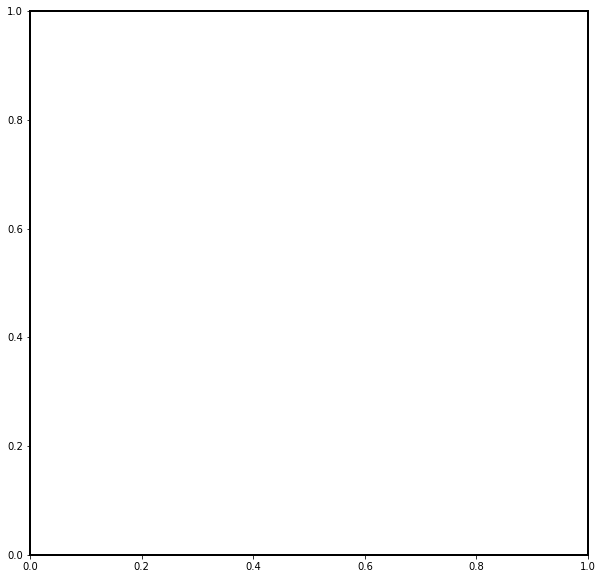

In [27]:
fix,ax = plt.subplots(figsize=(10,10))

colors = ['r','k','b','c','o','g']
i=0
for mesh_shapefile in mesh_shapefiles:
    tmp = gpd.read_file(mesh_shapefile)
    tmp.plot(ax=ax,color=colors[i])
    i=i+1

In [28]:
rectangular = True
      
if rectangular:
    print('Model domain is rectangular, clear North, South, West, and East Boundaries')
    extentpoly     = gpd.read_file("%s%s_extent_%s.shp" %(folders[7],AOI,EPSG))
    ulx,lry,lrx,uly = extentpoly.total_bounds   # Coordiates converted to UTM coordinate system
    temp, domain   = getpolygonpoints(extentpoly,ulx,uly,lrx,lry,base_length)
    perimeter = temp.length
    extent = tuple((point.coords[0][0],point.coords[0][1]) for point in (domain.geometry[:]))
    extent2 = []
    for feat in domain.geometry:
        extent2.append([round(feat.x,5), round(feat.y,5)])
    extent2 = np.array(extent2)
    north = np.where((extent2[:,1]==round(uly,5)))
    south = np.where((extent2[:,1]==round(lry,5)))
    west  = np.where((extent2[:,0]==round(ulx,5)))
    east  = np.where((extent2[:,0]==round(lrx,5)))
    other_tag = np.where((extent2[:,1]!=round(uly,5))&(extent2[:,1]!=round(lry,5))&(extent2[:,0]!=round(ulx,5))&(extent2[:,0]!=round(lrx,5)))
    print('There are a total of %s boundary nodes' %(len(domain)))
    print('There are %s boundary nodes tagged as North boundaries' %(len(north[0])))
    print('There are %s boundary nodes tagged as South boundaries' %(len(south[0])))
    print('There are %s boundary nodes tagged as West boundaries' %(len(west[0])))
    print('There are %s boundary nodes tagged as East boundaries' %(len(east[0])))
    print('There are %s boundary nodes tagged as Other boundaries' %(len(other_tag[0])))
  
else:
    tide_bnd = gpd.read_file("%s%s_tidebnd.shp" %(folders[0],AOI))
    print('Model domain is irregular, boundary tags are not North, South, East, and West')
    print('Tidal boundary is defined by user: \n%s%s_tidebnd.shp' %(folders[0],AOI))
    extentpoly     = gpd.read_file("%s%s_modeldomain.shp" %(folders[7],AOI))
    tide_bnd = tide_bnd.to_crs(extentpoly.crs)
    ulx,lry,lrx,uly = extentpoly.total_bounds   # Coordiates converted to UTM coordinate system
    temp, domain   = getpolygonpoints(extentpoly,ulx,uly,lrx,lry,base_length)
    perimeter = temp.length
    extent = tuple((round(point.coords[0][0],9),round(point.coords[0][1],9)) for point in (domain.geometry[:]))
#     extent2 = []
#     for feat in domain.geometry:
#         extent2.append([round(feat.x,5), round(feat.y,5)])
#     extent2 = np.array(extent2)
    domain['index'] = domain.index
    tide = gpd.overlay(domain,tide_bnd,how='intersection')
    tide_tag = np.array(tide['index'])
    
    other = gpd.overlay(domain,tide_bnd,how='difference')
    other_tag = np.array(other['index'])
    print('There are a total of %s boundary nodes' %(len(domain)))
    print('There are %s boundary nodes tagged as tidal boundaries' %(len(tide_tag)))
    print('There are %s boundary nodes tagged as not tidal boundaries' %(len(other_tag)))

np.savetxt('%s%s_domain_points.csv' %(mesh_path,AOI), extent,delimiter=',', fmt= '%1.9f') ## USED BY ANUGA MODEL



Model domain is rectangular, clear North, South, West, and East Boundaries
There are a total of 2486 boundary nodes
There are 769 boundary nodes tagged as North boundaries
There are 768 boundary nodes tagged as South boundaries
There are 475 boundary nodes tagged as West boundaries
There are 475 boundary nodes tagged as East boundaries
There are 0 boundary nodes tagged as Other boundaries


In [29]:
domain['index'] = domain.index.astype('int')
domain['tag'] = ''
if rectangular:

    domain['tag'][domain['index'].isin(north[0])] = 'north'
    domain['tag'][domain['index'].isin(south[0])] = 'south'
    domain['tag'][domain['index'].isin(west[0])] = 'west'
    domain['tag'][domain['index'].isin(east[0])] = 'east'
    domain['tag'][domain['index'].isin(other_tag[0])] = 'other'
else:
    domain['tag'][domain['index'].isin(other_tag[0])] = 'other'
    domain['tag'][domain['index'].isin(tide_tag[0])] = 'tag'

domain.to_file('%s%s_domain_points.shp' %(mesh_path,AOI))

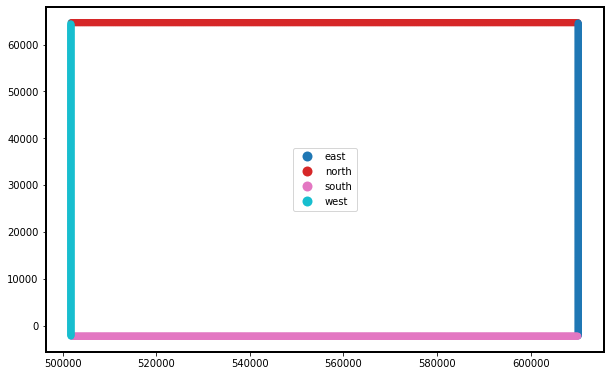

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
#boundary_segments.plot(ax=ax,column='boundary',categorical=True,legend=True,color='k')
domain.plot(ax=ax,column='tag',categorical=True,legend=True)
plt.savefig('%s/boundarytags.png' %(mesh_path))


In [31]:
bounding_polygon = anuga.read_polygon('%s%s_domain_points.csv' %(mesh_path,AOI))
A = anuga.polygon_area(bounding_polygon) / 1000000.0
print('################################# Bounding Polygon defined by :               %s_domain_points.csv' %(AOI))
print('################################# Area of bounding polygon:                   %.2f km^2' %(A))
print('################################# Base triangle area for unrefined areas:     %s km^2' %(base_length/1000000.00))



################################# Bounding Polygon defined by :               komo_domain_points.csv
################################# Area of bounding polygon:                   7255.78 km^2
################################# Base triangle area for unrefined areas:     0.000141 km^2


In [32]:
minlength = (min(mesh_triangles)*2)**0.5
maxlength = (max(mesh_triangles)*2)**0.5

interior_regions = []
missing = gpd.GeoDataFrame(columns =['geometry'], crs = EPSG)


In [33]:
# mesh=0
# mesh_triangle = mesh_triangles[mesh]        #zone_scale = int(parameters['Zone%sScale' %(zone)].astype('float64'))     # Maximum triangle area in Zone A areas
# print('################################# Max triangle area for %s:     %s km^2' %(mesh_names[mesh],mesh_triangle/1000000.00))


In [34]:
# mesh_shapefiles[:-1]

In [35]:
if uniform == False:
    for mesh in range(len(mesh_shapefiles[:-1])):
        print(mesh)
        try:
            mesh_triangle = mesh_triangles[mesh]        #zone_scale = int(parameters['Zone%sScale' %(zone)].astype('float64'))     # Maximum triangle area in Zone A areas
        except:''
        else:
            print('################################# Max triangle area for %s:     %s km^2' %(mesh_names[mesh],mesh_triangle/1000000.00))
            mesh_length = (mesh_triangle*2)**0.5 # max area = (max length/2)^2
            zone_polygons = []

            ## ZONE
            zone_polygon = gpd.read_file(mesh_shapefiles[mesh])
            #zone_polygon.geometry = zone_polygon.buffer(2*int(maxlength))
            zone_polygon.geometry = zone_polygon.buffer(-int(minlength))
            zone_no_holes,holes = delete_holes(zone_polygon)
            zone_no_holes = zone_no_holes.explode(index_parts = True).reset_index(drop=True)

            columns = zone_no_holes.columns[:-1]
            zone_no_holes.drop(columns,inplace=True,axis=1)
            zone_filled = zone_no_holes.copy(deep=True)
            points = {'geometry':[Point(zone_no_holes.geometry[0].exterior.coords[0][0], zone_no_holes.geometry[0].exterior.coords[0][1])]}
            points = gpd.GeoDataFrame(points,crs=EPSG)
            rivercsv = []
            for g in range(zone_filled.shape[0]):
                try:
                    interior_regions.append([anuga.read_polygon("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle)),mesh_triangle])

                except:
                    tempgdf = gpd.GeoDataFrame(geometry = zone_filled.loc[g])
                    #tempgdf.columns = ['geometry']
                    temp_filled,temp_points = getpolygonpoints(tempgdf,ulx,uly,lrx,lry,int(mesh_length))
                    if temp_points.shape[0]>3:
                        points_2,newxy = removenearbypoints(temp_points,domain, mesh_path,AOI,'%s%s' %(mesh_names[mesh],g),mesh_triangle,minlength)
                        np.savetxt("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle),newxy,delimiter=',', fmt= '%1.9f')
                        print('%s%s_%s_points_%s.csv' %(mesh_path,AOI,'%s%s' %(mesh_names[mesh],g),mesh_triangle))
                       #rivercsv.append(deltapath+folders[6]+delta+'_river%s_points.csv' %(g))
                        try:
                            interior_regions.append([anuga.read_polygon(mesh_path+AOI+'_%s%s_points_%s.csv' %(mesh_names[mesh],g,mesh_triangle)),mesh_triangle])
                        except: print('BAD POLYGON --> BAD MESH. Excluding this polygon for the mesh generator')
                        else:
                            zone_filled.loc[g].geometry = temp_filled.geometry[0]
                            points = pd.concat((points,points_2),axis=0)
                            points = points.reset_index(drop=True)
                else:
                    points_2 = gpd.read_file("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle))
                    #zone_filled.loc[g].geometry = temp_filled.geometry[0]
                    points = pd.concat((points,points_2),axis=0)
                    points = points.reset_index(drop=True)
                domain = pd.concat((domain,points),axis=0).reset_index(drop=True)
                missing = pd.concat((missing,zone_filled),axis=0)
            points.to_file("%s%s_points_%s_%s.shp" %(mesh_path,AOI,mesh_names[mesh],mesh_triangle))


    domain.to_file("%s%s_all_points.shp" %(mesh_path,AOI))

In [36]:
## This fills in the buffer zone between refinement areas
## Right now the mesh size of the buffer zone is set at the smallest mesh size
# inner_extent = extentpoly.copy(deep=True)
# inner_extent.geometry = extentpoly.buffer(-int(minlength)-10)
# gaps = gpd.overlay(inner_extent,missing,how='difference')




In [37]:
# import glob 
# TIDE_options = [(x.split('/')[-1].split('_')[1].split('LAT')[-1], x.split('/')[-1].split('_')[2].split('LON')[-1]) for x in glob.glob(f'{folders[5]}/Tide*')]
# #TIDE_options = [x.split('/')[-1] for x in glob.glob(f'{folders[5]}/Tide*')]
# print('\nTIDE (LAT,LON) options:')
# print(*TIDE_options,sep='\n')

# TIDE_option = TIDE_options[0]
# tide_name = [os.path.join(dirpath,f)
#             for dirpath,dirnames, files in os.walk(folders[5])
#             for f in fnmatch.filter(dirnames,'*%s*%s*' %(TIDE_option))][0]

# print('You picked TIDE %s' %(tide_name.split('/')[-1])) #LAT%s LON%s' %(tide_name))




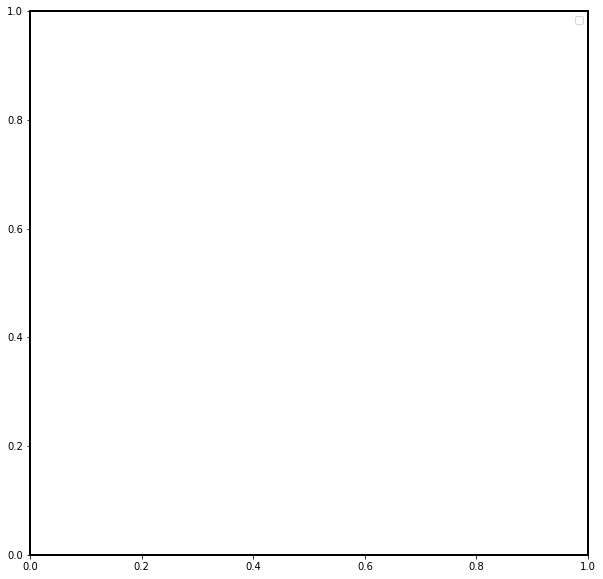

In [38]:
fix,ax = plt.subplots(figsize=(10,10))

colors = ['r','k','b','c','o','g']
for mesh in range(len(mesh_shapefiles[:-1])):
    tmp = gpd.read_file('%s%s_points_%s_%s.shp' %(mesh_path,AOI,mesh_names[mesh],mesh_triangles[mesh]))
    tmp.plot(ax=ax,color=colors[mesh],label=mesh_names[mesh])
    
ax.legend()

<font size = 5 color='red'> We now use ANUGA utilities to biuld the model mesh (Triangle Software)

In [39]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)

In [40]:
if os.path.isfile("%s%s_tidebnd.shp" %(folders[0],AOI)) == True:
    anuga.create_mesh_from_regions(
        bounding_polygon,
        boundary_tags={'Tide': tide_tag,
                       'exterior': other_tag},
        maximum_triangle_area = base_triangle,
        filename =  mesh_path + mesh_file + '.tsh',
        interior_regions = interior_regions,
        use_cache = False,
        verbose = False,
        poly_geo_reference=geo_reference,
        mesh_geo_reference=geo_reference,
        )
else:
    anuga.create_mesh_from_regions(
        bounding_polygon,
        boundary_tags={'North': north[0],
                       'East': east[0],
                       'South': south[0],
                       'West': west[0]},
        maximum_triangle_area = base_triangle,
        filename =  mesh_path + mesh_file + '.tsh',
        #interior_regions = interior_regions,
        use_cache = False,
        verbose = False,
        poly_geo_reference=geo_reference,
        mesh_geo_reference=geo_reference,
        )
    


In [47]:
#pip install backports.zoneinfo
mesh_domain = anuga.create_domain_from_file(mesh_path + mesh_file+'.tsh')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 3.5 MB/s 


<font size = 5 color = 'red'> Build run scripts for submitting to Gattaca or running locally </font>

Figure files for each frame will be stored in /content/drive/MyDrive/examples/komo/Meshes/TEST/Meshes_base_10000m2//plot/


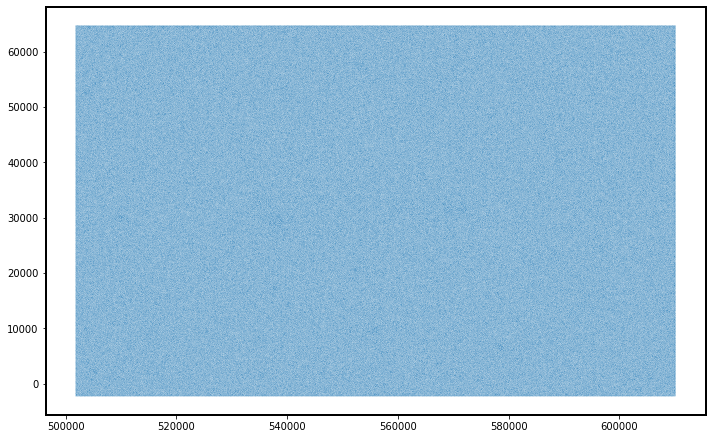

In [48]:
# filein = open(path_templates+ 'Run_Model_V0.py')
# template = Template(filein.read())
# replacements = {'config':'config_%s_%s.csv' %(AOI,datetime.now().strftime("%Y%m%d")),
#                 'SWOT_HYDROLOGY_TOOLBOX':'$SWOT_HYDROLOGY_TOOLBOX',
#                 'modelpath': modelpath}
# print('Mesh created is %s' %(meshname))

# runanuga = template.substitute(replacements)
# file = open('%s/%s_Run_Model_V0.py' %(modelpath,AOI),'w')
# file.write(runanuga)
# file.close()

# parameters.loc[0,'MeshName'] = mesh_string
# parameters.to_csv(modelpath + '/config_%s_%s.csv' %(AOI,datetime.now().strftime("%Y%m%d")))

# filein = open(path_template + 'submit_anuga.sh')
# template = Template(filein.read())
# replacements = {
#                 'delta':AOI,
#                 'localpath':hpc_path,
#                 'modelpath': modelpath,
#                 'memgb': '50gb',
#                 'cores': 48,
#                 'run_script':'%s_Run_Model_V0.py' %(delta)}
# print('Job submit file created is submit_job.sh')

# runanuga = template.substitute(replacements)
# file = open('%s/submit_anuga.sh' %(modelpath),'w')
# file.write(runanuga)
# file.close()

fig = plt.figure(figsize=(10,10))
dplotter = animate.Domain_plotter(mesh_domain,plot_dir = mesh_path + '/plot/')
plt.triplot(dplotter.triang,linewidth=0.1)
plt.axis('scaled')
plt.tight_layout()
plt.savefig('%s/plot/mesh%s.png' %(mesh_path,myid))


<font size= 5 color = 'red'> Initiate Timer

In [54]:

parameters.loc[0,'MeshName'] = mesh_file
parameters.to_csv(folders[6] + '/config_%s_%s.csv' %(AOI,datetime.now().strftime("%Y%m%d")))


In [52]:
folders

['/content/drive/MyDrive/examples/komo/User_Defined_Files/',
 '/content/drive/MyDrive/examples/komo/tmp/',
 '/content/drive/MyDrive/examples/komo/Setup_Files/',
 '/content/drive/MyDrive/examples/komo/Meshes/',
 '/content/drive/MyDrive/examples/komo/DEMs/',
 '/content/drive/MyDrive/examples/komo/Boundaries',
 '/content/drive/MyDrive/examples/komo/Simulations/',
 '/content/drive/MyDrive/examples/komo/Setup_Files/Setup_SHP/',
 '/content/drive/MyDrive/examples/komo/Setup_Files/Setup_RST/',
 '/content/drive/MyDrive/examples/komo/Setup_Files/Setup_FIG/']